# コードのテスト
## tuning.optuna_train_base.py について
- optunaでハイパーパラメータチューニング

In [1]:
#import os
#gpu_num = '3'
#os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_num)

In [1]:
# モジュールimport
import os, sys, glob, time, shutil
sys.path.append(r'C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py')
from dataset import plot_log, prepare_data, util, plot_12task_log, util, set_split
from transformer import get_train_valid_test, my_generator
from model import define_model, multi_loss, my_callback, my_metric, my_class_weight 
from predicter import roc_curve, pr_curve, conf_matrix, multi_predict, grad_cam, ensemble_predict, base_predict, grad_cam_util
from tuning import optuna_train_base, optuna_train_Tox21

import keras
import keras.backend as K
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

%matplotlib inline
# これを書くとjupyterでmatplotlibなどが出力する画像の解像度が上がる
%config InlineBackend.figure_format = 'retina'

%reload_ext autoreload
%autoreload 2

plot_log.py: loaded as module file
prepare_data.py: loaded as module file
util.py: loaded as module file
plot_12task_log.py: loaded as module file
set_split.py: loaded as module file


Using TensorFlow backend.


my_generator.py: loaded as module file
get_train_valid_test.py: loaded as module file
define_model.py: loaded as module file
multi_loss.py: loaded as module file
my_callback.py: loaded as module file
my_metric.py: loaded as module file
my_class_weight.py: loaded as module file
roc_curve.py: loaded as module file
pr_curve.py: loaded as module file
conf_matrix.py: loaded as module file
multi_predict.py: loaded as module file
grad_cam.py: loaded as module file
ensemble_predict.py: loaded as module file
base_predict.py: loaded as module file
grad_cam_util.py: loaded as module file
optuna_train_base.py: loaded as module file
optuna_train.py: loaded as module file


### 犬猫画像パスとラベル取得
- https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765


# クラス名のリスト
class_name = ['Cat', 'Dog']

# cat, dog 全画像格納しているディレクトリ
source_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\images\kagglecatsanddogs_3367a\PetImages'

# train/validation/test set に分ける画像ディレクトリ
img_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set'

# 出力ディレクトリクリア（削除）
shutil.rmtree(img_dir)

train_1class_count = 500 # train 1クラスの画像枚数
valid_1class_count = 200 # validaiton 1クラスの画像枚数
test_1class_count = 100  # test 1クラスの画像枚数

# クラスディレクトリごとに別れた指定ディレクトリの画像を tarin/val set に分けてコピーする
set_split.split_class_train_valid_test_set(class_name, source_dir, img_dir
                                           , train_count_org=train_1class_count
                                           , valid_count_org=valid_1class_count
                                           , test_count_org=test_1class_count
                                          )

### 固定パラメータ

In [4]:
# 出力ディレクトリ
output_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\results\test\02_keras_py_experiment_041_v2_test_tuning_optuna_train_base'
os.makedirs(output_dir, exist_ok=True)

# 入力ディレクトリ
train_data_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\train'
train_samples = util.file_count(train_data_dir, r'.jpg')

validation_data_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\validation'
val_samples = util.file_count(validation_data_dir, r'.jpg')

# テスト画像ディレクトリ
test_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\test'

# 入力層のサイズ
#img_rows, img_cols, channels=331, 331, 3
img_rows, img_cols, channels=100, 100, 3

# 分類クラス
class_name = ['Cat', 'Dog']
classes = class_name#['0', '1']
nb_classes = len(classes)
activation='softmax'

# GradCamで切り出す層名
layer_name = 'block5_conv3'

# ハイパーパラメータ
num_epoch=3#10
batch_size=10
val_batch_size=10
test_batch_size=10

# optimizer のパラメータ
choice_optim='sgd'
lr=0.1 * batch_size / 128
#decay=1e-3
momentum=0.9

# fine-tuningモデル
#choice_model='InceptionResNetV2'
#trainable=761
choice_model='VGG16'
trainable=15

# 全結合層
FCnum=1
Dence=128

# 学習打ち切りオプション
early_stopping=10

### 訓練画像水増しオプション
# ImageDataGenerator
rescale=1.0/255.0
horizontal_flip=True
zoom_range=0.2
rotation_range=20
#channel_shift_range=5.
#brightness_range=[0.3, 1.0]
# custom param
mix_up_alpha=0.2# mixup alpha
#random_crop=[224,224]# random_crop size
random_erasing_prob = 0.5 # random_erasing 確率
random_erasing_maxpixel = 255

# MyImageDataGenerator のオプションを辞書型で詰める
my_IDG_options={'rescale': rescale
                , 'horizontal_flip': horizontal_flip
                , 'zoom_range': zoom_range
                , 'rotation_range': rotation_range 
                #, 'channel_shift_range': channel_shift_range
                #, 'brightness_range': brightness_range
                , 'mix_up_alpha': mix_up_alpha
                , 'random_erasing_prob': random_erasing_prob
                , 'random_erasing_maxpixel': random_erasing_maxpixel
               }

### データ管理クラス定義

In [5]:
%%time
d_cls = get_train_valid_test.LabeledDataset([img_rows, img_cols, channels]
                                            , batch_size
                                            , valid_batch_size=val_batch_size
                                            , test_batch_size=test_batch_size
                                            , train_samples=1000
                                            , valid_samples=400)

d_cls.create_my_generator_flow_from_directory(train_data_dir
                                              , classes
                                              , valid_data_dir=validation_data_dir
                                              , test_data_dir=test_dir
                                              , color_mode='rgb'
                                              , class_mode='categorical'
                                              , my_IDG_options=my_IDG_options)

train_steps_per_epoch : 100
valid_steps_per_epoch : 40
my_IDG_options: {'rescale': 0.00392156862745098, 'horizontal_flip': True, 'zoom_range': 0.2, 'rotation_range': 20, 'mix_up_alpha': 0.2, 'random_erasing_prob': 0.5, 'random_erasing_maxpixel': 255}
Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Wall time: 238 ms


Found 1000 images belonging to 2 classes.
(10, 100, 100, 3)
(10, 2)
[0.99898808 0.00101192]
['Cat', 'Dog']


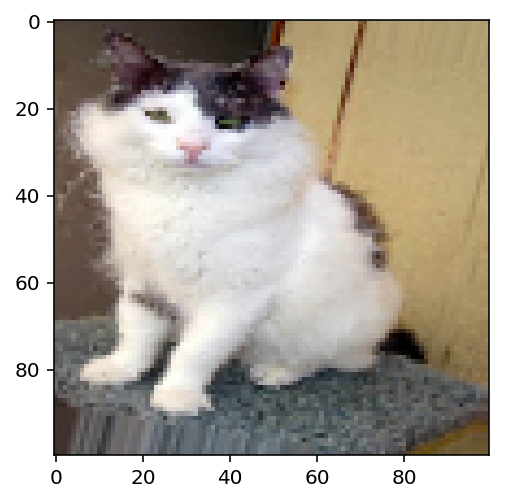

In [6]:
x,y = next(d_cls.train_gen)
print(x.shape)
print(y.shape)
print(y[0])
print(classes)
plt.imshow(x[0])
plt.show()

### モデル定義

In [7]:
model, orig_model = define_model.get_fine_tuning_model(output_dir, img_rows, img_cols, channels, nb_classes
                                                       , choice_model, trainable
                                                       , FCnum=FCnum
                                                       , Dence_1=Dence
                                                       , activation=activation
                                                       , add_se=False
                                                      )
# compile the model
optim = define_model.get_optimizers(choice_optim=choice_optim, lr=lr, momentum=momentum, nesterov=True)#, decay=decay)
#lr_metric = my_metric.get_lr_metric(optim)
model.compile(loss='categorical_crossentropy'
              , optimizer=optim
              , metrics=['accuracy'])
              #, metrics=['accuracy', lr_metric])

# finetunning用にレイヤーの数と名前を表示
count= 0
for layer in model.layers:
    print(count, layer.name)
    count+=1
keras.utils.plot_model(model, to_file=os.path.join(output_dir, 'model.svg'), show_shapes=True)

print(model.summary())


def get_cb(output_dir, cosine_annealing_num_epoch=None):
    cb = []

    # 学習率をエポック増やすごとにコサインカーブで上げ下げする. epochsはコサインカーブのほぼ半周期になるエポック数
    cb.append(my_callback.cosine_annealing(epochs=num_epoch))

    # ログを保存するカスタムコールバック
    cb.append(my_callback.tsv_logger(os.path.join(output_dir, 'tsv_logger.tsv')))
    
    # epochごとに学習曲線保存する自作callback
    cb.append(my_callback.learning_curve_plot(os.path.join(output_dir, 'learning_curve.png')))
    
    # 各エポックでval_lossが最小となるモデル保存
    cb.append(keras.callbacks.ModelCheckpoint(filepath=os.path.join(output_dir, 'finetuning.h5'), monitor='val_loss', save_best_only=True, verbose=1))

    # 過学習の抑制 <early_stopping_pati>step続けてval_loss減らなかったら打ち切る
    cb.append(keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stopping, verbose=1))
    
    return cb



----- model_param -----
output_dir = D:\work\kaggle_data\Cats_VS._Dogs\results\test\02_keras_py_experiment_041_v2_test_tuning_optuna_train_base
img_rows img_cols channels = 100 100 3
num_classes = 2
choice_model trainable = VGG16 15
FCnum = 1
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True


C:\Users\shingo\Anaconda3\envs\tfgpu_py36_v3\lib\site-packages\keras\models.py:255: UserWarning:

No training configuration found in save file: the model was *not* compiled. Compile it manually.



----- FC_layer -----
dence dropout addBatchNorm kernel_initializer l2_rate = 128 0.5 None he_normal 0.0001
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.0078125 0.9 0.0 True
0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 FC_avg
20 FC1_dence
21 FC1_dropout
22 pred
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
____

### 学習実行

In [6]:
%%time
start_time = time.time()
history = model.fit_generator(
    d_cls.train_gen,
    steps_per_epoch = d_cls.init_train_steps_per_epoch,# 1エポックあたりの学習(step)回数
    epochs = num_epoch,# エポック数
    validation_data = d_cls.valid_gen,# 検証ファイル生成
    validation_steps = d_cls.init_valid_steps_per_epoch,# 検証するファイル数
    verbose = 2,# 1:ログをプログレスバーで標準出力 2:最低限の情報のみ出す
    callbacks = get_cb(output_dir, cosine_annealing_num_epoch=None)
    )
end_time = time.time()
print("Elapsed Time : {:.2f}sec".format(end_time - start_time))

Epoch 1/3
 - 10s - loss: 0.6774 - acc: 0.6000 - val_loss: 0.5288 - val_acc: 0.7800

Epoch 00001: val_loss improved from inf to 0.52881, saving model to D:\work\kaggle_data\Cats_VS._Dogs\results\test\02_keras_py_experiment_041_v2_test_tuning_optuna_train_base\finetuning.h5
Epoch 2/3
 - 8s - loss: 0.5524 - acc: 0.7490 - val_loss: 0.3569 - val_acc: 0.8700

Epoch 00002: val_loss improved from 0.52881 to 0.35689, saving model to D:\work\kaggle_data\Cats_VS._Dogs\results\test\02_keras_py_experiment_041_v2_test_tuning_optuna_train_base\finetuning.h5
Epoch 3/3
 - 8s - loss: 0.5035 - acc: 0.7960 - val_loss: 0.4048 - val_acc: 0.8375

Epoch 00003: val_loss did not improve
Elapsed Time : 27.34sec
Wall time: 27.3 s


C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py\dataset\plot_log.py:16: FutureWarning:

read_table is deprecated, use read_csv instead, passing sep='\t'.



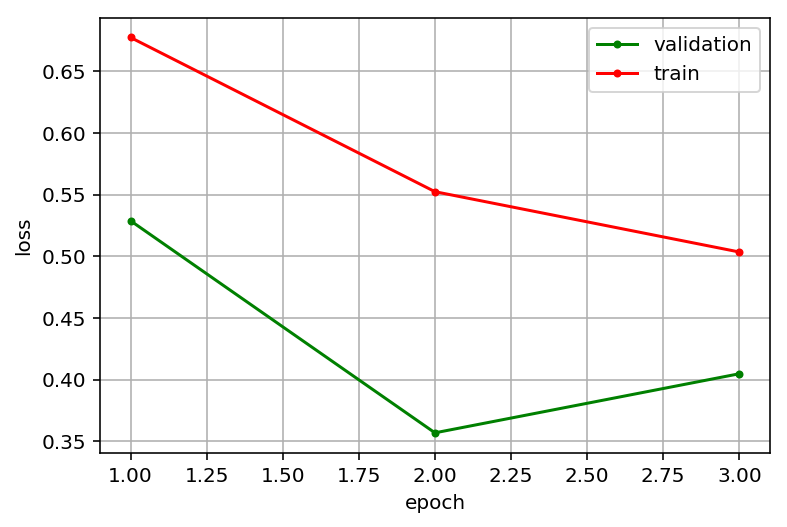

<Figure size 432x288 with 0 Axes>

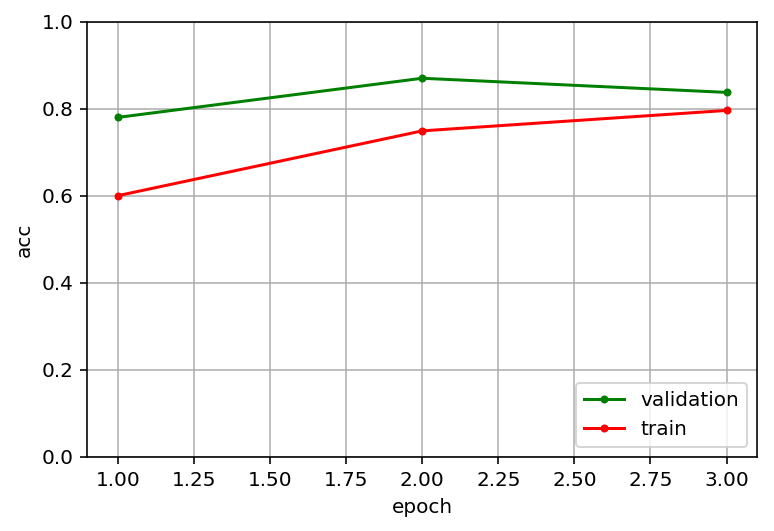

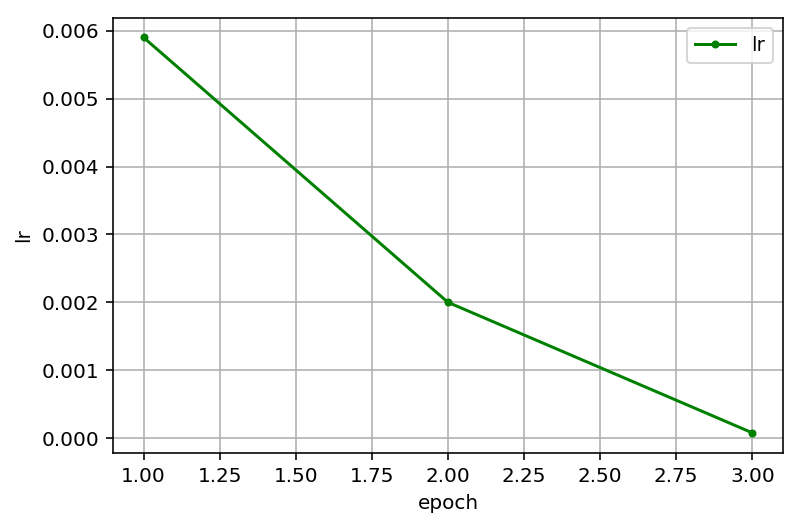

<Figure size 432x288 with 0 Axes>

In [7]:
plot_log.plot_results(output_dir, os.path.join(output_dir, 'tsv_logger.tsv'))

val_loss =  0.3568865111097693
val_acc =  0.8699999943375587

test_loss =  0.33049384988844394
test_acc =  0.8900000005960464
conf_matrix.py: loaded as module file
------------------------------------
out_dir: D:\work\kaggle_data\Cats_VS._Dogs\results\test\02_keras_py_experiment_041_v2_test_tuning_optuna_train_base
              precision    recall  f1-score   support

         Cat       0.87      0.92      0.89       100
         Dog       0.91      0.86      0.89       100

   micro avg       0.89      0.89      0.89       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.89      0.89      0.89       200

Confusion matrix, without normalization


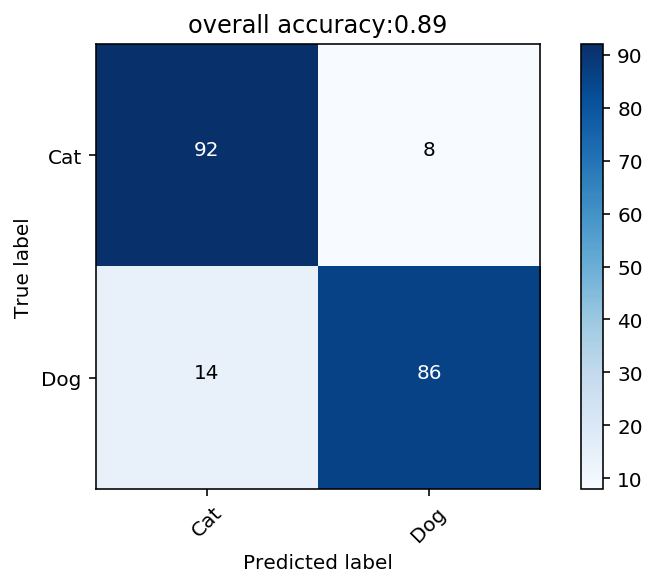

<Figure size 432x288 with 0 Axes>

In [8]:
# evaluate_generator() はモデルのコンパイル必要
model = keras.models.load_model(os.path.join(output_dir, 'finetuning.h5'), compile=True)

scoreSeg = model.evaluate_generator(d_cls.valid_gen)
print("val_loss = ",scoreSeg[0])
print("val_acc = ",scoreSeg[1])

scoreSeg = model.evaluate_generator(d_cls.test_gen)
print("\ntest_loss = ",scoreSeg[0])
print("test_acc = ",scoreSeg[1])

# generatorでtest set全件予測
pred_df = base_predict.pred_classes_generator(model, d_cls.test_gen, classes_list=class_name)
pred_df.to_csv(os.path.join(output_dir, 'pred.tsv'), sep='\t')
#print(pred_df.head())

# 予測結果のデータフレームから混同行列作成
base_predict.conf_matrix_from_pred_classes_generator(pred_df, classes, output_dir, is_label_print=False)

D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\test\Cat\3638.jpg


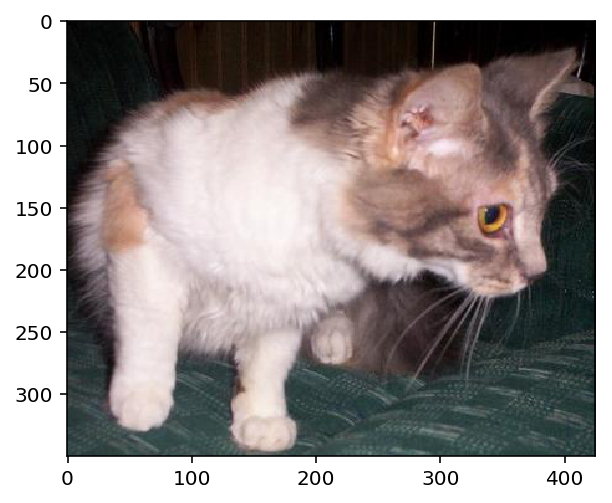

predict_score: [[0.57 0.43]]
classes: ['Cat', 'Dog']
max_pred_label:  Cat
Tensor("block5_conv3_1/Relu:0", shape=(?, 6, 6, 512), dtype=float32)
Tensor("gradients_2/block5_pool_1/MaxPool_grad/MaxPoolGrad:0", shape=(?, 6, 6, 512), dtype=float32)


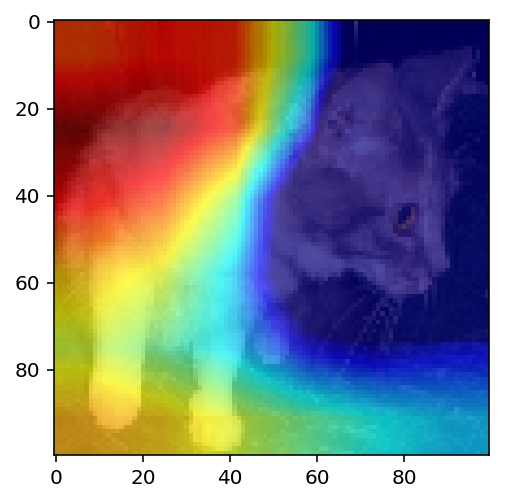

out_jpg: D:\work\kaggle_data\Cats_VS._Dogs\results\test\02_keras_py_experiment_041_v2_test_tuning_optuna_train_base\gradcam\TP\Cat_3638.jpg_pred_Cat_0.57.jpg
D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\test\Dog\4656.jpg


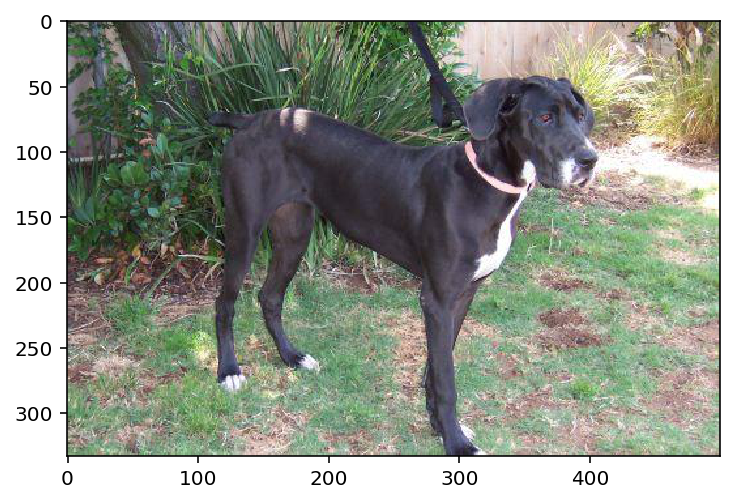

predict_score: [[0.03 0.97]]
classes: ['Cat', 'Dog']
max_pred_label:  Dog
Tensor("block5_conv3_1/Relu:0", shape=(?, 6, 6, 512), dtype=float32)
Tensor("gradients_3/block5_pool_1/MaxPool_grad/MaxPoolGrad:0", shape=(?, 6, 6, 512), dtype=float32)


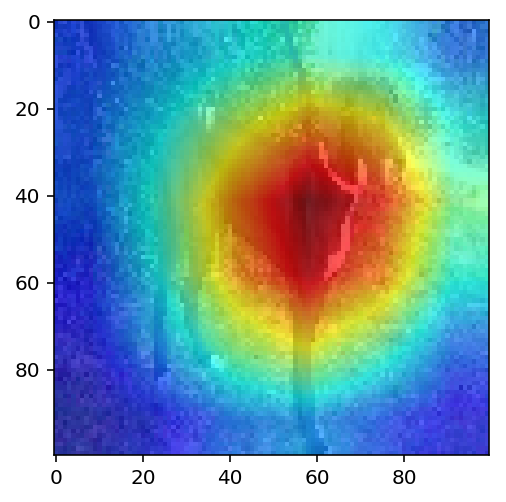

out_jpg: D:\work\kaggle_data\Cats_VS._Dogs\results\test\02_keras_py_experiment_041_v2_test_tuning_optuna_train_base\gradcam\TP\Dog_4656.jpg_pred_Dog_0.97.jpg


In [10]:
for i in [50, 150]:
    # 画像1件のxからgradcam実行+ファイル出力
    grad_cam_img = grad_cam_util.gradcam_from_img_path(model
                                                       , os.path.join(test_dir, d_cls.test_gen.filenames[i])
                                                       , output_dir
                                                       , classes
                                                       , img_rows, img_cols
                                                       , layer_name=layer_name)

# --------------------------------------------------------------------------------------------
# Optunaで学習実行
### 目的関数の定義

In [8]:
# モジュールimport
import os, sys, glob, time, shutil
sys.path.append(r'C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py')
from dataset import plot_log, prepare_data, util, plot_12task_log, util, set_split
from transformer import get_train_valid_test, my_generator
from model import define_model, multi_loss, my_callback, my_metric, my_class_weight 
from predicter import roc_curve, conf_matrix, multi_predict, grad_cam, ensemble_predict, base_predict, grad_cam_util#, pr_curve
from tuning import optuna_train_base, optuna_train_Tox21

import keras
import keras.backend as K
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import optuna

%matplotlib inline
# これを書くとjupyterでmatplotlibなどが出力する画像の解像度が上がる
%config InlineBackend.figure_format = 'retina'

%reload_ext autoreload
%autoreload 2


# 出力ディレクトリ
output_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\results\test\02_keras_py_experiment_041_v2_test_tuning_optuna_train_base\optuna'
os.makedirs(output_dir, exist_ok=True)

# 入力層のサイズ
img_rows, img_cols, channels=100, 100, 3
#img_rows, img_cols, channels=456, 456, 3

# ハイパーパラメータ
num_epoch=3#10
batch_size=2#10
val_batch_size=batch_size
test_batch_size=batch_size
class_name = ['Cat', 'Dog']
loss='categorical_crossentropy'
activation='softmax'
metrics=['acc']
kernel_initializer=['he_normal']
l2=[0.0001]

# 入力ディレクトリ
train_data_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\train'
train_samples = util.file_count(train_data_dir, r'.jpg')

validation_data_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\validation'
val_samples = util.file_count(validation_data_dir, r'.jpg')

# テスト画像ディレクトリ
test_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\test'

# 画像管理クラス
d_cls=get_train_valid_test.LabeledDataset([img_rows, img_cols, channels]
                                          , batch_size
                                          , valid_batch_size=val_batch_size
                                          , test_batch_size=test_batch_size
                                          , train_samples=1000
                                          , valid_samples=400
                                         )

# 基本コールバック
def get_cb(output_dir, cosine_annealing_num_epoch=None):
    cb = []

    # ログを保存するカスタムコールバック
    cb.append(my_callback.tsv_logger(os.path.join(output_dir, 'tsv_logger.tsv')))
    
    # epochごとに学習曲線保存する自作callback
    cb.append(my_callback.learning_curve_plot(os.path.join(output_dir, 'learning_curve.png')))
    
    # 各エポックでval_lossが最小となるモデル保存
    #cb.append(keras.callbacks.ModelCheckpoint(filepath=os.path.join(output_dir, 'finetuning.h5'), monitor='val_loss', save_best_only=True, verbose=1))

    # 過学習の抑制 <early_stopping_pati>step続けてval_loss減らなかったら打ち切る
    cb.append(keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1))
    
    return cb

## best_parameter をval_loss でとる
return_val_loss=True

### チューニング可能パラメータ引数 ###
## model param
choice_model = ['VGG16']# 学習済みモデル
#choice_model = ['EfficientNet']# 学習済みモデル
efficientnet_num = [0,2,4,5]
trainable = [15] # 重みは全層学習させる（重みunfreeze開始レイヤーを番号で指定できる）
FCnum = [1] # FC層の数
Dence = [128] # FC層のユニット数
Dropout = [0.5] # FC層のDropout
choice_optim = ['sgd'] # optimizer
lr = [0.1 * batch_size / 128] # （初期）学習率
callback_lr = ['cosine_annealing'] # 学習率変更するcallback
callback_save_model=False#True # 全モデル保存するcallback つけるか. False ならbest modelだけ保存

if callback_save_model == True:
    model_dir = os.path.join(output_dir, 'model_weight_optuna')
    if os.path.exists(model_dir) == True:
        shutil.rmtree(model_dir) # モデルディレクトリすでにあれば一旦削除

# クラスの不均衡を考慮して、トレーニングデータのclass_weight
class_weight = my_class_weight.cal_weight(class_name, train_data_dir)

## ImageDataGenerator param
rescale=1.0/255.0
horizontal_flip=[True]
zoom_range=0.2
rotation_range=20
# custom param
#random_crop=[224,224]# random_crop size
random_erasing_prob = [0.5] # random_erasing 確率
random_erasing_maxpixel = 255
mix_up_alpha=[0.2]# mixup alpha
ricap_beta=[0.3]

# パラメータを引数に持たせてoptunaの目的関数を定義
objective = optuna_train_base.Objective(output_dir, d_cls
                                        , train_data_dir=train_data_dir
                                        , validation_data_dir=validation_data_dir
                                        , shape=[img_rows, img_cols, channels]
                                        , num_classes=len(class_name)
                                        , class_name=class_name
                                        , epochs=num_epoch
                                        , loss=loss
                                        , metrics=metrics
                                        , verbose=2
                                        , activation=activation
                                        , callbacks=get_cb(output_dir)
                                        , callback_save_model=callback_save_model
                                        , choice_model=choice_model
                                        , trainable=trainable
                                        , pred_kernel_initializer='zeros'
                                        , pred_l2_rate=0.0001
                                        , l2=l2
                                        , FCnum=FCnum
                                        , Dence=Dence
                                        , Dropout=Dropout
                                        , kernel_initializer=kernel_initializer
                                        , choice_optim=choice_optim
                                        , lr=lr
                                        , callback_lr=callback_lr
                                        , class_weight=class_weight
                                        , rescale=rescale
                                        , horizontal_flip=horizontal_flip
                                        , rotation_range_min=-1.0*zoom_range
                                        , rotation_range_max=zoom_range
                                        , zoom_range_low_min=1.0-zoom_range
                                        , zoom_range_low_max=1.0-zoom_range
                                        , zoom_range_high_min=1.0+zoom_range
                                        , zoom_range_high_max=1.0+zoom_range
                                        , random_erasing_prob=random_erasing_prob
                                        , random_erasing_maxpixel=random_erasing_maxpixel
                                        , mix_up_alpha=mix_up_alpha
                                        , ricap_beta=ricap_beta
                                        , efficientnet_num=efficientnet_num
                                        , trial_best_loss=1000.0 # 全trialでval_lossがbestのモデルファイルを保存するか判定用
                                        , trial_best_metrics=1000.0 # 全trialでval_accがbestのモデルファイルを保存するか判定用
                                        , type='class' # 分類か回帰のフラグ
                                       )

train_steps_per_epoch : 500
valid_steps_per_epoch : 200


### 最適化の実行

In [9]:
%%time
# sqlite 使って履歴ファイル作る
sqllite_path = output_dir+'/example.db'
if os.path.exists(sqllite_path) == True:
    os.remove(sqllite_path) # sqllite_pathすでにあれば一旦削除
study = optuna.create_study(study_name='example-study'
                            , storage='sqlite:///'+sqllite_path
                            , load_if_exists=True # すでに DB が存在していた場合はそのデータを読み込んで、最適化を再開
                           )

study.optimize(objective, n_trials=4)

[I 2019-06-30 19:46:55,934] A new study created with name: example-study


----- model_param -----
output_dir = D:\work\kaggle_data\Cats_VS._Dogs\results\test\02_keras_py_experiment_041_v2_test_tuning_optuna_train_base\optuna
img_rows img_cols channels = 100 100 3
num_classes = 2
choice_model trainable = VGG16 15
FCnum = 1
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
----- FC_layer -----
dence dropout addBatchNorm kernel_initializer l2_rate = 128 0.5 None he_normal 0.0001
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.0015625 0.9 0.0 True
my_IDG_options: {'rescale': 0.00392156862745098, 'horizontal_flip': True, 'vertical_flip': False, 'rotation_range': 0.2, 'zoom_range': [0.8, 1.2], 'shear_range': 0.0, 'channel_shift_range': 0.0, 'brightness_range': [1.0, 1.0], 'random_crop': None, 'mix_up_alpha': 0.2, 'random_erasing_prob': 0.5, 'random_erasing_maxpixel': 255, 'ricap_beta': 0.3, 'ricap_use_same_random_value_on_batch': True}
Found 400 images b

[I 2019-06-30 19:50:58,369] Finished trial#0 resulted in value: 0.4105261475592852. Current best value is 0.4105261475592852 with parameters: {'Dence_1': 128, 'Dropout': 0.5, 'FCnum': 1, 'FCpool': 'GlobalAveragePooling2D', 'addBatchNorm': None, 'add_se': False, 'branch_Tox21_12task': False, 'callback_lr': 'cosine_annealing', 'choice_model': 'VGG16', 'choice_optim': 'sgd', 'decay': 0.0, 'efficientnet_num': 4, 'horizontal_flip': True, 'kernel_initializer': 'he_normal', 'l2': 0.0001, 'lr': 0.0015625, 'mix_up_alpha': 0.2, 'random_erasing_prob': 0.5, 'ricap_beta': 0.3, 'ricap_use_same_random_value_on_batch': True, 'sedensenet_num': None, 'seresnet_num': None, 'seresnext_num': None, 'trainable': 15, 'vertical_flip': False}.


----- model_param -----
output_dir = D:\work\kaggle_data\Cats_VS._Dogs\results\test\02_keras_py_experiment_041_v2_test_tuning_optuna_train_base\optuna
img_rows img_cols channels = 100 100 3
num_classes = 2
choice_model trainable = VGG16 15
FCnum = 1
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
----- FC_layer -----
dence dropout addBatchNorm kernel_initializer l2_rate = 128 0.5 None he_normal 0.0001
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.0015625 0.9 0.0 True
my_IDG_options: {'rescale': 0.00392156862745098, 'horizontal_flip': True, 'vertical_flip': False, 'rotation_range': 0.2, 'zoom_range': [0.8, 1.2], 'shear_range': 0.0, 'channel_shift_range': 0.0, 'brightness_range': [1.0, 1.0], 'random_crop': None, 'mix_up_alpha': 0.2, 'random_erasing_prob': 0.5, 'random_erasing_maxpixel': 255, 'ricap_beta': 0.3, 'ricap_use_same_random_value_on_batch': True}
Found 400 images b

[I 2019-06-30 19:52:12,404] Finished trial#1 resulted in value: 0.4166250218078494. Current best value is 0.4105261475592852 with parameters: {'Dence_1': 128, 'Dropout': 0.5, 'FCnum': 1, 'FCpool': 'GlobalAveragePooling2D', 'addBatchNorm': None, 'add_se': False, 'branch_Tox21_12task': False, 'callback_lr': 'cosine_annealing', 'choice_model': 'VGG16', 'choice_optim': 'sgd', 'decay': 0.0, 'efficientnet_num': 4, 'horizontal_flip': True, 'kernel_initializer': 'he_normal', 'l2': 0.0001, 'lr': 0.0015625, 'mix_up_alpha': 0.2, 'random_erasing_prob': 0.5, 'ricap_beta': 0.3, 'ricap_use_same_random_value_on_batch': True, 'sedensenet_num': None, 'seresnet_num': None, 'seresnext_num': None, 'trainable': 15, 'vertical_flip': False}.


----- model_param -----
output_dir = D:\work\kaggle_data\Cats_VS._Dogs\results\test\02_keras_py_experiment_041_v2_test_tuning_optuna_train_base\optuna
img_rows img_cols channels = 100 100 3
num_classes = 2
choice_model trainable = VGG16 15
FCnum = 1
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
----- FC_layer -----
dence dropout addBatchNorm kernel_initializer l2_rate = 128 0.5 None he_normal 0.0001
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.0015625 0.9 0.0 True
my_IDG_options: {'rescale': 0.00392156862745098, 'horizontal_flip': True, 'vertical_flip': False, 'rotation_range': 0.2, 'zoom_range': [0.8, 1.2], 'shear_range': 0.0, 'channel_shift_range': 0.0, 'brightness_range': [1.0, 1.0], 'random_crop': None, 'mix_up_alpha': 0.2, 'random_erasing_prob': 0.5, 'random_erasing_maxpixel': 255, 'ricap_beta': 0.3, 'ricap_use_same_random_value_on_batch': True}
Found 400 images b

[I 2019-06-30 19:53:22,269] Finished trial#2 resulted in value: 0.41061580698005856. Current best value is 0.4105261475592852 with parameters: {'Dence_1': 128, 'Dropout': 0.5, 'FCnum': 1, 'FCpool': 'GlobalAveragePooling2D', 'addBatchNorm': None, 'add_se': False, 'branch_Tox21_12task': False, 'callback_lr': 'cosine_annealing', 'choice_model': 'VGG16', 'choice_optim': 'sgd', 'decay': 0.0, 'efficientnet_num': 4, 'horizontal_flip': True, 'kernel_initializer': 'he_normal', 'l2': 0.0001, 'lr': 0.0015625, 'mix_up_alpha': 0.2, 'random_erasing_prob': 0.5, 'ricap_beta': 0.3, 'ricap_use_same_random_value_on_batch': True, 'sedensenet_num': None, 'seresnet_num': None, 'seresnext_num': None, 'trainable': 15, 'vertical_flip': False}.


----- model_param -----
output_dir = D:\work\kaggle_data\Cats_VS._Dogs\results\test\02_keras_py_experiment_041_v2_test_tuning_optuna_train_base\optuna
img_rows img_cols channels = 100 100 3
num_classes = 2
choice_model trainable = VGG16 15
FCnum = 1
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
----- FC_layer -----
dence dropout addBatchNorm kernel_initializer l2_rate = 128 0.5 None he_normal 0.0001
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.0015625 0.9 0.0 True
my_IDG_options: {'rescale': 0.00392156862745098, 'horizontal_flip': True, 'vertical_flip': False, 'rotation_range': 0.2, 'zoom_range': [0.8, 1.2], 'shear_range': 0.0, 'channel_shift_range': 0.0, 'brightness_range': [1.0, 1.0], 'random_crop': None, 'mix_up_alpha': 0.2, 'random_erasing_prob': 0.5, 'random_erasing_maxpixel': 255, 'ricap_beta': 0.3, 'ricap_use_same_random_value_on_batch': True}
Found 400 images b

[I 2019-06-30 19:55:47,890] Finished trial#3 resulted in value: 0.4191060439683497. Current best value is 0.4105261475592852 with parameters: {'Dence_1': 128, 'Dropout': 0.5, 'FCnum': 1, 'FCpool': 'GlobalAveragePooling2D', 'addBatchNorm': None, 'add_se': False, 'branch_Tox21_12task': False, 'callback_lr': 'cosine_annealing', 'choice_model': 'VGG16', 'choice_optim': 'sgd', 'decay': 0.0, 'efficientnet_num': 4, 'horizontal_flip': True, 'kernel_initializer': 'he_normal', 'l2': 0.0001, 'lr': 0.0015625, 'mix_up_alpha': 0.2, 'random_erasing_prob': 0.5, 'ricap_beta': 0.3, 'ricap_use_same_random_value_on_batch': True, 'sedensenet_num': None, 'seresnet_num': None, 'seresnext_num': None, 'trainable': 15, 'vertical_flip': False}.


Wall time: 8min 56s


### 結果の確認

In [6]:
# 試行結果データフレームで出力
sqllite_path = output_dir+'/example.db'
study = optuna.Study(study_name='example-study', storage='sqlite:///'+sqllite_path)
df = study.trials_dataframe()
df.to_csv(os.path.join(output_dir, 'optuna_lgb.tsv'), sep='\t')
df

number                state     value             datetime_start  \
                                                                     
0      0  TrialState.COMPLETE  0.619677 2019-06-19 00:45:05.636624   
1      1  TrialState.COMPLETE  0.544733 2019-06-19 00:55:11.511037   
2      2  TrialState.COMPLETE  0.679758 2019-06-19 01:04:24.300312   
3      3  TrialState.COMPLETE  0.528393 2019-06-19 01:18:47.224473   

           datetime_complete  params                                        \
                             Dence_1 Dropout FCnum                  FCpool   
0 2019-06-19 00:55:11.362628     128     0.5     1  GlobalAveragePooling2D   
1 2019-06-19 01:04:23.881022     128     0.5     1  GlobalAveragePooling2D   
2 2019-06-19 01:18:47.057290     128     0.5     1  GlobalAveragePooling2D   
3 2019-06-19 01:27:13.605118     128     0.5     1  GlobalAveragePooling2D   

                ...     user_attrs                                \
  addBatchNorm  ...          shape shear_range val_acc  val_loss   
0         None  ...  [456, 456, 3]         0.0  0.9125  0.619677   
1         None  ...  [456, 456, 3]         0.0  0.9775  0.544733   
2         None  ...  [456, 456, 3]         0.0  0.5550  0.679758   
3         None  ...  [456, 456, 3]         0.0  0.9375  0.528393   

                                 system_attrs intermediate_values            \
  zoom_range_high zoom_range_low      _number                   0         1   
0             1.2            0.8            0            0.671692  0.620743   
1             1.2            0.8            1            0.642544  0.549436   
2             1.2            0.8            2            0.697238  0.679758   
3             1.2            0.8            3            0.640946  0.529895   

             
          2  
0  0.619677  
1  0.544733  
2  0.680425  
3  0.528393  

[4 rows x 56 columns]

In [7]:
# study.best_params ファイル出力
f = open(os.path.join(output_dir, 'best_params.txt'), 'w') # 書き込みモードで開く
for key,value in sorted(study.best_params.items()):
    f.write('{0}\t{1}\n'.format(key, value))
f.close() # ファイル閉じる
study.best_params

{'Dence_1': 128,
 'Dropout': 0.5,
 'FCnum': 1,
 'FCpool': 'GlobalAveragePooling2D',
 'addBatchNorm': None,
 'add_se': False,
 'branch_Tox21_12task': False,
 'callback_lr': 'cosine_annealing',
 'choice_model': 'EfficientNet',
 'choice_optim': 'sgd',
 'decay': 0.0,
 'efficientnet_num': 0,
 'horizontal_flip': True,
 'kernel_initializer': 'he_normal',
 'l2': 0.0001,
 'lr': 0.0015625,
 'mix_up_alpha': 0.2,
 'random_erasing_prob': 0.5,
 'ricap_beta': 0.3,
 'ricap_use_same_random_value_on_batch': True,
 'sedensenet_num': None,
 'seresnet_num': None,
 'seresnext_num': None,
 'trainable': 15,
 'vertical_flip': False}

In [8]:
# optunw v 0.7.0
from optuna.visualization import plot_intermediate_values
plot_intermediate_values(study)

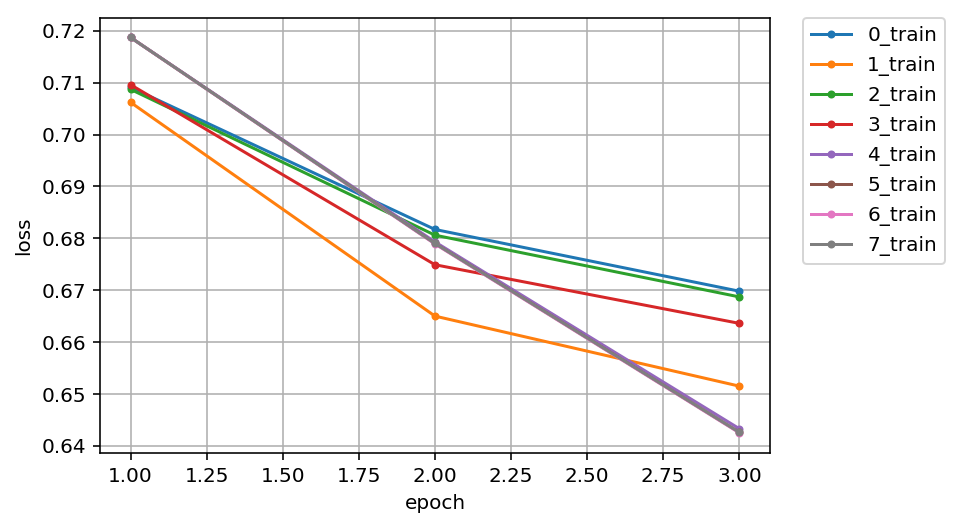

<Figure size 432x288 with 0 Axes>

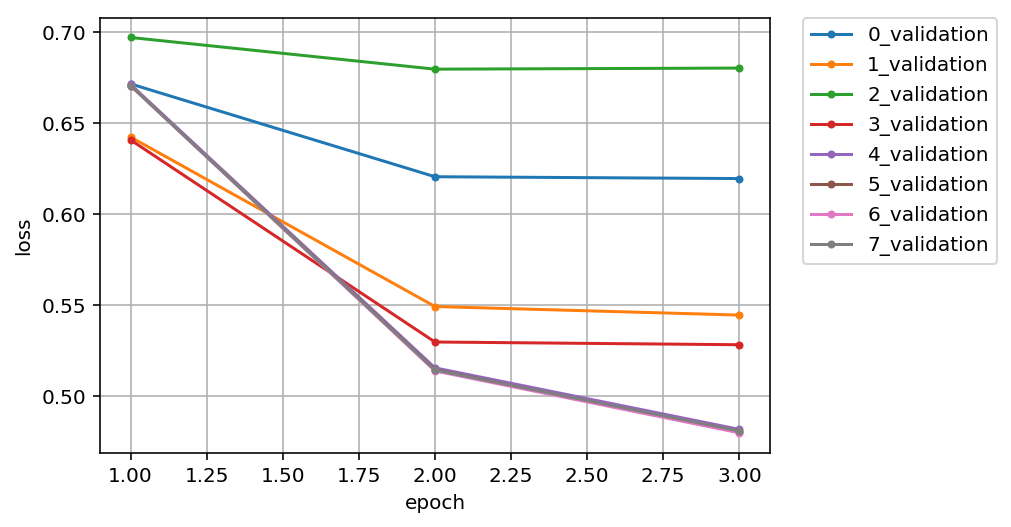

<Figure size 432x288 with 0 Axes>

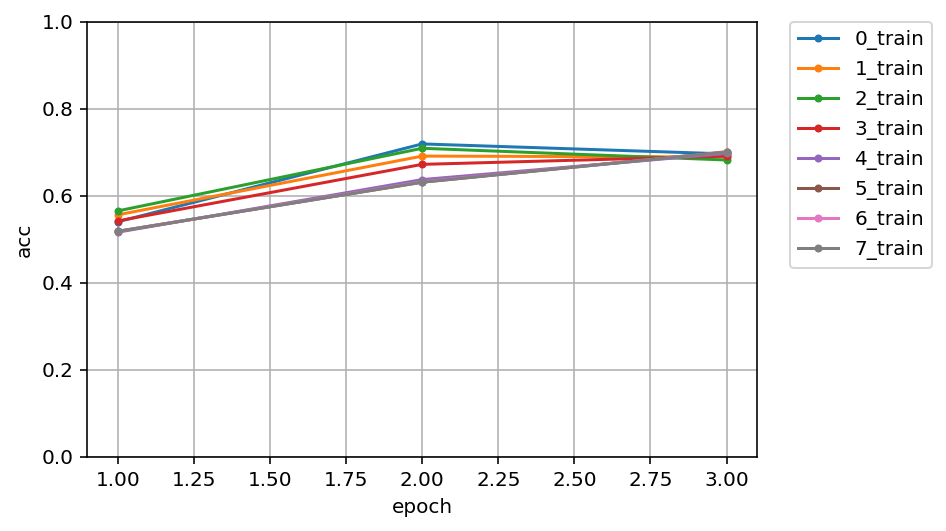

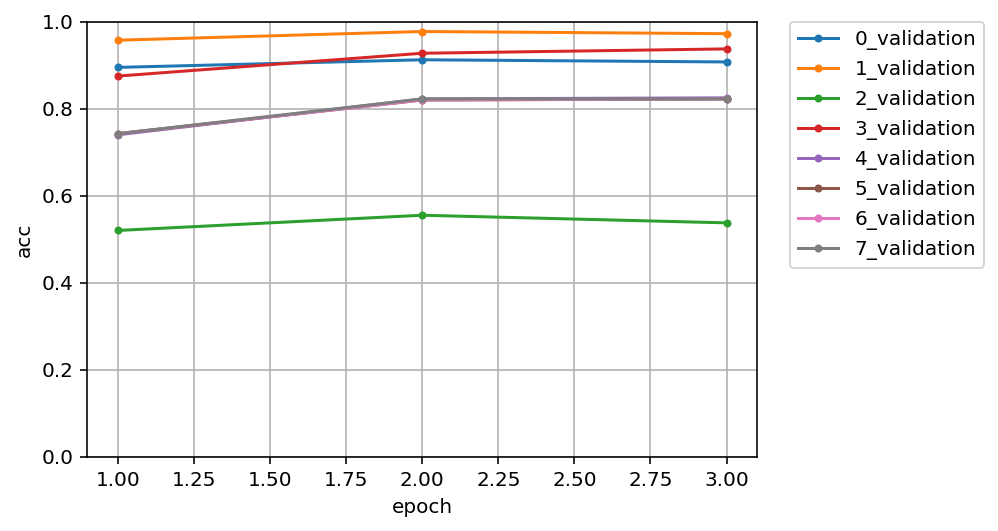

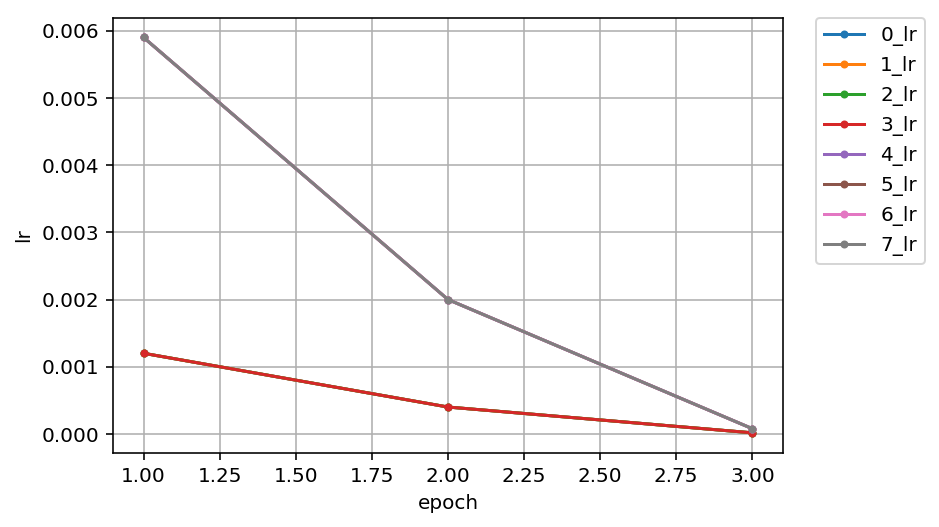

<Figure size 432x288 with 0 Axes>

In [9]:
hist_file_list = glob.glob(output_dir+'/tsv_logger/*.tsv')
plot_log.overlaid_plot_results(output_dir, hist_file_list)

## predict確認

D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\test\Cat\3638.jpg


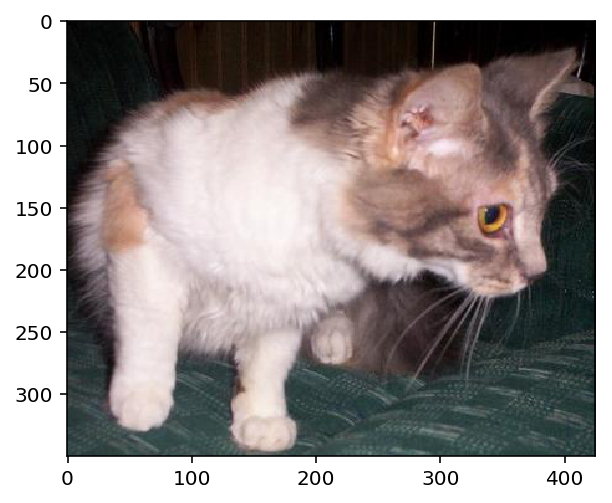

predict_score: [[0.57899487 0.42100513]]
classes: ['Cat', 'Dog']
max_pred_label:  Cat
D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\test\Dog\4656.jpg


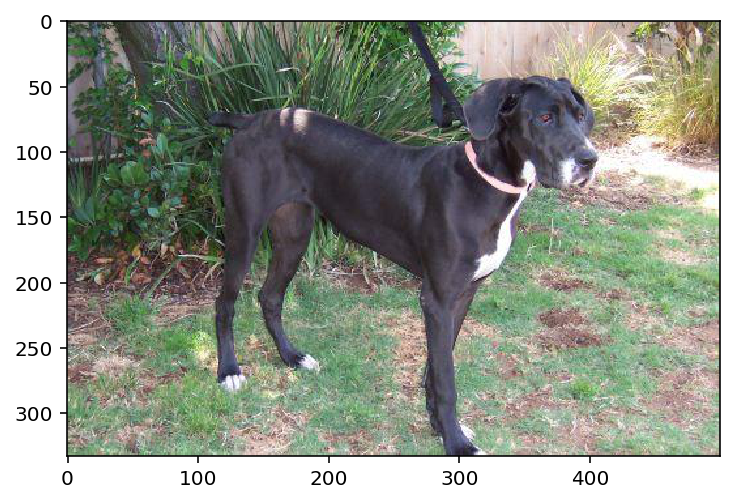

predict_score: [[0.2681073 0.7318927]]
classes: ['Cat', 'Dog']
max_pred_label:  Dog


(1, 0.7318927)

In [10]:
#h5_path_list = glob.glob(os.path.join(output_dir, 'model_weight_optuna/**h5'))
#model = keras.models.load_model(h5_path_list[0], compile=False)
model = keras.models.load_model(os.path.join(output_dir, 'best_trial_loss.h5'), compile=False)

out_predict_dir = os.path.join(output_dir, 'predict/test')
os.makedirs(out_predict_dir, exist_ok=True)

pred_paths=glob.glob(test_dir+'/*/*jpg')
base_predict.pred_from_1img(model, pred_paths[50], img_rows, img_cols, classes=class_name)
base_predict.pred_from_1img(model, pred_paths[150], img_rows, img_cols, classes=class_name)

In [10]:
%debug

> <ipython-input-9-62c7ea2463f6>(3)<module>()
      1 h5_path_list = glob.glob(os.path.join(output_dir, 'model_weight_optuna/**h5'))
      2 
----> 3 model = keras.models.load_model(h5_path_list[0], compile=False)
      4 
      5 pred_paths=glob.glob(os.path.join(test_dir, '*jpg'))

ipdb> p h5_path_list
[]
ipdb> q


## iphoneの画像で試す

In [7]:
# モジュールimport
import os, sys, glob, time, shutil
sys.path.append(r'C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py')
from dataset import plot_log, prepare_data, util, plot_12task_log, util, pr_curve, set_split
from transformer import get_train_valid_test, my_generator
from model import define_model, multi_loss, my_callback, my_metric, my_class_weight 
from predicter import roc_curve, conf_matrix, multi_predict, grad_cam, ensemble_predict, base_predict, grad_cam_util
from tuning import optuna_train_base, optuna_train_Tox21

import keras
import keras.backend as K
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import optuna

%matplotlib inline
# これを書くとjupyterでmatplotlibなどが出力する画像の解像度が上がる
%config InlineBackend.figure_format = 'retina'


# 出力ディレクトリ
output_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\results\test\02_keras_py_experiment_041_v2_test_tuning_optuna_train_base\optuna_iphone'
os.makedirs(output_dir, exist_ok=True)

# 入力層のサイズ
img_rows, img_cols, channels=100, 100, 3

# ハイパーパラメータ
num_epoch=3#10
batch_size=5
val_batch_size=batch_size
test_batch_size=1
class_name = ['beagle', 'bikini', 'boke', 'cat', 'comic_book', 'fashion', 'marin', 'other', 'shingo', 'suit', 'tumblr']
loss='categorical_crossentropy'
activation='softmax'
metrics=['acc']

# 入力ディレクトリ
# 入力ディレクトリ
#train_data_dir = r'D:\work\keras_iPhone_pictures\InceptionResNetV2_small_set\train_400\train'
train_data_dir = r'D:\work\keras_iPhone_pictures\InceptionResNetV2_small_set\train_400\validation'
train_samples = util.file_count(train_data_dir, r'.JPG')+util.file_count(train_data_dir, r'.PNG')+util.file_count(train_data_dir, r'.jpg')+util.file_count(train_data_dir, r'.png') 
print('train_samples:', train_samples)

validation_data_dir = r'D:\work\keras_iPhone_pictures\InceptionResNetV2_small_set\train_400\validation'
valid_samples = util.file_count(validation_data_dir, r'.JPG')+util.file_count(validation_data_dir, r'.PNG')+util.file_count(validation_data_dir, r'.jpg')+util.file_count(validation_data_dir, r'.png')
print('valid_samples:', valid_samples)

# テスト画像ディレクトリ
test_dir = r'D:\work\keras_iPhone_pictures\InceptionResNetV2_small_set\train_400\test'
test_samples = util.file_count(test_dir, r'.JPG')+util.file_count(test_dir, r'.PNG')+util.file_count(test_dir, r'.jpg')+util.file_count(test_dir, r'.png')
print('test_samples:', test_samples)

# 画像管理クラス
d_cls=get_train_valid_test.LabeledDataset([img_rows, img_cols, channels]
                                          , batch_size
                                          , valid_batch_size=val_batch_size
                                          , test_batch_size=test_batch_size
                                          , train_samples=train_samples
                                          , valid_samples=valid_samples
                                         )

# 基本コールバック
def get_cb(output_dir, cosine_annealing_num_epoch=None):
    cb = []

    # ログを保存するカスタムコールバック
    cb.append(my_callback.tsv_logger(os.path.join(output_dir, 'tsv_logger.tsv')))
    
    # epochごとに学習曲線保存する自作callback
    cb.append(my_callback.learning_curve_plot(os.path.join(output_dir, 'learning_curve.png')))
    
    # 各エポックでval_lossが最小となるモデル保存
    #cb.append(keras.callbacks.ModelCheckpoint(filepath=os.path.join(output_dir, 'finetuning.h5'), monitor='val_loss', save_best_only=True, verbose=1))

    # 過学習の抑制 <early_stopping_pati>step続けてval_loss減らなかったら打ち切る
    cb.append(keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1))
    
    return cb

### チューニング可能パラメータ引数 ###
## model param
choice_model = ['VGG16']# 学習済みモデル
trainable = [15] # 重みは全層学習させる（重みunfreeze開始レイヤーを番号で指定できる）
FCnum = [1] # FC層の数
Dence = [128] # FC層のユニット数
Dropout = [0.5] # FC層のDropout
kernel_initializer=['he_normal']
l2=[0.0001]
choice_optim = ['sgd'] # optimizer
lr = [0.1 * batch_size / 128] # （初期）学習率
callback_lr = ['cosine_annealing'] # 学習率変更するcallback
callback_save_model=True # モデル保存するcallback つけるか. False なら保存しない

if callback_save_model == True:
    model_dir = os.path.join(output_dir, 'model_weight_optuna')
    if os.path.exists(model_dir) == True:
        shutil.rmtree(model_dir) # モデルディレクトリすでにあれば一旦削除

# クラスの不均衡を考慮して、トレーニングデータのclass_weight
class_weight = my_class_weight.cal_weight(class_name, train_data_dir)

## ImageDataGenerator param
rescale=1.0/255.0
horizontal_flip=[True]
zoom_range=0.2
rotation_range=20
# custom param
#random_crop=[224,224]# random_crop size
random_erasing_prob = [0.5] # random_erasing 確率
random_erasing_maxpixel = 255
mix_up_alpha=[0.2]# mixup alpha

train_samples: 338
valid_samples: 338
test_samples: 85
train_steps_per_epoch : 67
valid_steps_per_epoch : 67


### 普通に実行

In [8]:
%%time
my_IDG_options={'rescale': rescale
                , 'horizontal_flip': horizontal_flip[0]
                , 'zoom_range': zoom_range
                , 'rotation_range': rotation_range 
                , 'random_erasing_prob': random_erasing_prob[0]
                , 'random_erasing_maxpixel': random_erasing_maxpixel
                , 'mix_up_alpha': mix_up_alpha[0]
               }

d_cls.create_my_generator_flow_from_directory(train_data_dir
                                              , class_name
                                              , valid_data_dir=validation_data_dir
                                              , color_mode='rgb'
                                              , class_mode='categorical'
                                              , my_IDG_options=my_IDG_options)

model, orig_model = define_model.get_fine_tuning_model(output_dir, img_rows, img_cols, channels
                                                       , len(class_name)
                                                       , choice_model[0], trainable[0]
                                                       , FCnum=FCnum[0]
                                                       , Dence_1=Dence[0]
                                                       , activation=activation)
# compile the model
optim = define_model.get_optimizers(choice_optim=choice_optim[0], lr=lr[0])#, momentum=momentum, nesterov=True)#, decay=decay)
#lr_metric = my_metric.get_lr_metric(optim)
model.compile(loss=loss
              , optimizer=optim
              , metrics=metrics)
              #, metrics=['accuracy', lr_metric])
    
history = model.fit_generator(
    d_cls.train_gen,
    steps_per_epoch = d_cls.init_train_steps_per_epoch,# 1エポックあたりの学習(step)回数
    epochs = num_epoch,# エポック数
    validation_data = d_cls.valid_gen,# 検証ファイル生成
    validation_steps = d_cls.init_valid_steps_per_epoch,# 検証するファイル数
    verbose = 2,# 1:ログをプログレスバーで標準出力 2:最低限の情報のみ出す
    callbacks = get_cb(output_dir, cosine_annealing_num_epoch=None)
    , class_weight=class_weight
    )

my_IDG_options: {'rescale': 0.00392156862745098, 'horizontal_flip': True, 'zoom_range': 0.2, 'rotation_range': 20, 'random_erasing_prob': 0.5, 'random_erasing_maxpixel': 255, 'mix_up_alpha': 0.2}
Found 338 images belonging to 11 classes.
----- model_param -----
output_dir = D:\work\kaggle_data\Cats_VS._Dogs\results\test\02_keras_py_experiment_041_v2_test_tuning_optuna_train_base\optuna_iphone
img_rows img_cols channels = 100 100 3
num_classes = 11
choice_model trainable = VGG16 15
FCnum = 1
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
add_se = False
----- FC_layer -----
dence dropout addBatchNorm kernel_initializer l2_rate = 128 0.5 None he_normal 0.0001
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.00390625 0.9 0.0 True
Epoch 1/3
Found 338 images belonging to 11 classes.
67/67 [==============================] - ETA: 49s - loss: 2.4176 - acc: 0.20 - ETA: 32s - loss: 2.

KeyboardInterrupt: 

In [ ]:
## best_parameter をval_loss でとる
return_val_loss=True

# パラメータを引数に持たせてoptunaの目的関数を定義
objective = optuna_train_base.Objective(output_dir, d_cls
                                        , train_data_dir=train_data_dir
                                        , validation_data_dir=validation_data_dir
                                        , shape=[img_rows, img_cols, channels]
                                        , num_classes=len(class_name)
                                        , class_name=class_name
                                        , epochs=num_epoch
                                        , loss=loss
                                        , metrics=metrics
                                        , verbose=2
                                        , activation=activation
                                        , callbacks=get_cb(output_dir)
                                        , callback_save_model=callback_save_model
                                        , choice_model=choice_model
                                        , trainable=trainable
                                        , pred_kernel_initializer='zeros'
                                        , pred_l2_rate=0.0001
                                        , l2=l2
                                        , FCnum=FCnum
                                        , Dence=Dence
                                        , Dropout=Dropout
                                        , kernel_initializer=kernel_initializer
                                        , choice_optim=choice_optim
                                        , lr=lr
                                        , callback_lr=callback_lr
                                        , class_weight=class_weight
                                        , rescale=rescale
                                        , horizontal_flip=horizontal_flip
                                        , rotation_range_min=-1.0*zoom_range
                                        , rotation_range_max=zoom_range
                                        , zoom_range_low_min=1.0-zoom_range
                                        , zoom_range_low_max=1.0-zoom_range
                                        , zoom_range_high_min=1.0+zoom_range
                                        , zoom_range_high_max=1.0+zoom_range
                                        , random_erasing_prob=random_erasing_prob
                                        , random_erasing_maxpixel=random_erasing_maxpixel
                                        , mix_up_alpha=mix_up_alpha
                                       )

In [24]:
%%time
# sqlite 使って履歴ファイル作る
sqllite_path = output_dir+'/example.db'
if os.path.exists(sqllite_path) == True:
    os.remove(sqllite_path) # sqllite_pathすでにあれば一旦削除
study = optuna.create_study(study_name='example-study', storage='sqlite:///'+sqllite_path)

study.optimize(objective, n_trials=2)

[I 2019-03-17 16:26:46,443] A new study created with name: example-study


----- model_param -----
output_dir = D:\work\kaggle_data\Cats_VS._Dogs\results\test\02_keras_py_experiment_041_v2_test_tuning_optuna_train_base\optuna_iphone
img_rows img_cols channels = 100 100 3
num_classes = 11
choice_model trainable = VGG16 15
FCnum = 1
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
add_se = False
----- FC_layer -----
dence dropout addBatchNorm kernel_initializer l2_rate = 128 0.5 None he_normal 0.0001
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.00390625 0.9 0.0 True
my_IDG_options: {'rescale': 0.00392156862745098, 'horizontal_flip': True, 'vertical_flip': False, 'rotation_range': 0.2, 'zoom_range': [0.8, 1.2], 'shear_range': 0.0, 'channel_shift_range': 0.0, 'brightness_range': [1.0, 1.0], 'random_crop': None, 'mix_up_alpha': 0.2, 'random_erasing_prob': 0.5, 'random_erasing_maxpixel': 255, 'ricap_beta': 0.0, 'ricap_use_same_random_value_on_batch': 

KeyboardInterrupt: 